### aim: 

### date: 

In [61]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [62]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [63]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [64]:
def make_yearlist_ERA(yrst, yrend):
    
    baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/daily'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/ERA5_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def make_yearlist_UKESM(yrst, yrend):
    
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/UKESM_1A_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


ylist_UKESM = xr.open_mfdataset(make_yearlist_UKESM(1940,2019))
ylist_ERA = xr.open_mfdataset(make_yearlist_ERA(1940,2019))


In [65]:
ylist_UKESM_DJF = ylist_UKESM.wspd10m.sel(time_counter=(ylist_UKESM['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_UKESM_MAM = ylist_UKESM.wspd10m.sel(time_counter=(ylist_UKESM['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_UKESM_JJA = ylist_UKESM.wspd10m.sel(time_counter=(ylist_UKESM['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_UKESM_SON = ylist_UKESM.wspd10m.sel(time_counter=(ylist_UKESM['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_UKESM_FY = ylist_UKESM.wspd10m.\
groupby('time_counter.year').mean().mean(dim = 'year')

ylist_ERA_DJF = ylist_ERA.wspd10m.sel(time_counter=(ylist_ERA['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_ERA_MAM = ylist_ERA.wspd10m.sel(time_counter=(ylist_ERA['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_ERA_JJA = ylist_ERA.wspd10m.sel(time_counter=(ylist_ERA['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_ERA_SON = ylist_ERA.wspd10m.sel(time_counter=(ylist_ERA['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().mean(dim = 'year')
ylist_ERA_FY = ylist_ERA.wspd10m.\
groupby('time_counter.year').mean().mean(dim = 'year')

In [66]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = 8)
        cb.set_ticks(tticks, fontsize = 80)
        cb.ax.tick_params(labelsize=8)
    return cb


## potential colorbar imporvement code: 
https://matplotlib.org/stable/gallery/axes_grid1/demo_edge_colorbar.html

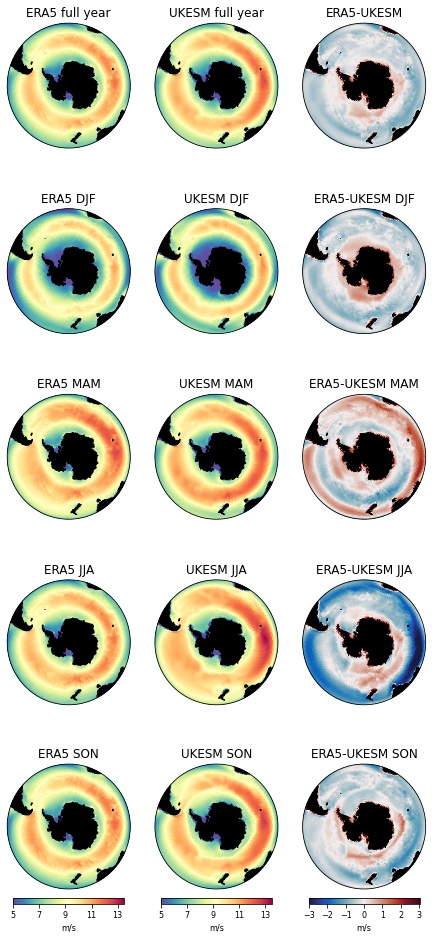

In [67]:
spbot = 5; sptop = 13.5; spint = 2
difbot = -3; diftop = 3.01; difint = 1
tcm = 'Spectral_r'

lats = ylist_ERA_FY.lat
lons = ylist_ERA_FY.lon

fact = 0.25
fig = plt.figure(figsize=[30*fact, 66*fact])


tits = ['ERA5 full year', 'UKESM full year', 'ERA5-UKESM',
       'ERA5 DJF', 'UKESM DJF', 'ERA5-UKESM DJF','ERA5 MAM', 'UKESM MAM', 'ERA5-UKESM MAM',\
        'ERA5 JJA', 'UKESM JJA', 'ERA5-UKESM JJA','ERA5 SON', 'UKESM SON', 'ERA5-UKESM SON']

toplot = [ylist_ERA_FY.values, ylist_UKESM_FY.values,\
          ylist_ERA_FY.values -ylist_UKESM_FY.values,\
          ylist_ERA_DJF.values, ylist_UKESM_DJF.values,\
          ylist_ERA_DJF.values -ylist_UKESM_DJF.values,\
          ylist_ERA_MAM.values, ylist_UKESM_MAM.values,\
          ylist_ERA_MAM.values -ylist_UKESM_MAM.values,\
          ylist_ERA_JJA.values, ylist_UKESM_JJA.values,\
          ylist_ERA_JJA.values -ylist_UKESM_JJA.values,\
          ylist_ERA_SON.values, ylist_UKESM_SON.values,\
          ylist_ERA_SON.values -ylist_UKESM_SON.values,\
         ]
      
cms = [tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance]
bb = [spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot, spbot, spbot, difbot]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop, sptop, sptop, diftop]
intvl = [spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint]
#test = seasmean_map_ts_ukesm[0,0,:,:]


for i in range(0,15):
    test = toplot[i]
    botbound = bb[i]
    topbound = tb[i]
    tint = intvl[i]
    if i >= 12:
        tcbr = True
    else:
        tcbr = False
    ax1 = fig.add_subplot(5, 3, i+1, projection=ccrs.Orthographic(0, -90))
    bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                  topbound, np.arange(botbound,topbound,tint), fs = 12, 
                  tit = tits[i], cbarlab = 'm/s', tcmap = cms[i], lm = True, cbr = tcbr)
    
#plt.suptitle('seasonal wind speed climatology, 1950-2020', y = 0.90)
plt.tight_layout()
fig.savefig('./figs/Fig_climatologymap_UKESM_ERA.jpg', dpi = 300)

## make meshmask 

In [68]:
make = False

if make:
    w = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/paperFigures/regrid_forcing/TOM12_1960_Cflx.nc')
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    data_vars = {'csize':(['y', 'x'], tmesh.csize.values,
    {
    'long_name':'area of cell in m2'}),
    }
    attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/FigMAP-HOV.ipynb',

    }

    tits = np.zeros([12,149,182])
    for i in range(0,12):
        tits[i,:,:] = tmesh.csize.values

    w.Cflx.values = tits
    w['aream2'] = w['Cflx']
    w = w.drop('Cflx')
    w.attrs = attrs
    w.assign(data_vars)

    w.to_netcdf('./PlankTOMmaskKURVA.nc')

    plt.figure()
    plt.pcolormesh(w2.aream2[0,:,:])

    plt.figure()
    plt.pcolormesh(ylist_ERA_FY.values)

#cdo remapbil,r360x180 PlankTOMmaskKURVA.nc PlankTOMmask_krg.nc

### weighted hovmoller 


In [69]:
mask = xr.open_dataset('PlankTOMmask_krg.nc')

ylist_ERA_FY_ts = ylist_ERA.wspd10m.\
groupby('time_counter.year').mean()

In [70]:
mask_area = mask.aream2.mean(dim = ['time_counter'])

ylist_ERA_FY_ts = ylist_ERA.wspd10m.isel(lat=slice(0,60)).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_ERA_FY_50 = ylist_ERA.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60)).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_ERA_FY_trend = ylist_ERA_FY_ts-ylist_ERA_FY_50

###
ylist_ERA_DJF_ts = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_ERA_DJF_50 = ylist_ERA.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_ERA_DJF_50 = ylist_ERA_DJF_50.sel(time_counter=(ylist_ERA_DJF_50['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_ERA_DJF_trend = ylist_ERA_DJF_ts-ylist_ERA_DJF_50
###
ylist_ERA_MAM_ts = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_ERA_MAM_50 = ylist_ERA.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_ERA_MAM_50 = ylist_ERA_MAM_50.sel(time_counter=(ylist_ERA_MAM_50['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_ERA_MAM_trend = ylist_ERA_MAM_ts-ylist_ERA_MAM_50
###
###
ylist_ERA_JJA_ts = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_ERA_JJA_50 = ylist_ERA.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_ERA_JJA_50 = ylist_ERA_JJA_50.sel(time_counter=(ylist_ERA_JJA_50['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_ERA_JJA_trend = ylist_ERA_JJA_ts-ylist_ERA_JJA_50
###
ylist_ERA_SON_ts = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_ERA_SON_50 = ylist_ERA.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_ERA_SON_50 = ylist_ERA_SON_50.sel(time_counter=(ylist_ERA_SON_50['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_ERA_SON_trend = ylist_ERA_SON_ts-ylist_ERA_SON_50

In [71]:
mask_area = mask.aream2.mean(dim = ['time_counter'])

ylist_UKESM_FY_ts = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_UKESM_FY_50 = ylist_UKESM.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60)).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_UKESM_FY_trend = ylist_UKESM_FY_ts-ylist_UKESM_FY_50

###
ylist_UKESM_DJF_ts = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_UKESM['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_UKESM_DJF_50 = ylist_UKESM.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_UKESM_DJF_50 = ylist_UKESM_DJF_50.sel(time_counter=(ylist_UKESM_DJF_50['time_counter.season'] == 'DJF')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_UKESM_DJF_trend = ylist_UKESM_DJF_ts-ylist_UKESM_DJF_50
###
ylist_UKESM_MAM_ts = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_UKESM['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_UKESM_MAM_50 = ylist_UKESM.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_UKESM_MAM_50 = ylist_UKESM_MAM_50.sel(time_counter=(ylist_UKESM_MAM_50['time_counter.season'] == 'MAM')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_UKESM_MAM_trend = ylist_UKESM_MAM_ts-ylist_UKESM_MAM_50
###
###
ylist_UKESM_JJA_ts = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_UKESM['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_UKESM_JJA_50 = ylist_UKESM.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_UKESM_JJA_50 = ylist_UKESM_JJA_50.sel(time_counter=(ylist_UKESM_JJA_50['time_counter.season'] == 'JJA')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_UKESM_JJA_trend = ylist_UKESM_JJA_ts-ylist_UKESM_JJA_50
###
ylist_UKESM_SON_ts = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_UKESM['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).T
ylist_UKESM_SON_50 = ylist_UKESM.wspd10m.sel(time_counter =slice("1940-01-01", "1950-01-02")).isel(lat=slice(0,60))
ylist_UKESM_SON_50 = ylist_UKESM_SON_50.sel(time_counter=(ylist_UKESM_SON_50['time_counter.season'] == 'SON')).\
groupby('time_counter.year').mean().\
weighted(mask_area.isel(lat=slice(0,60))).mean(dim = ['lon']).mean(dim = 'year').T
ylist_UKESM_SON_trend = ylist_UKESM_SON_ts-ylist_UKESM_SON_50

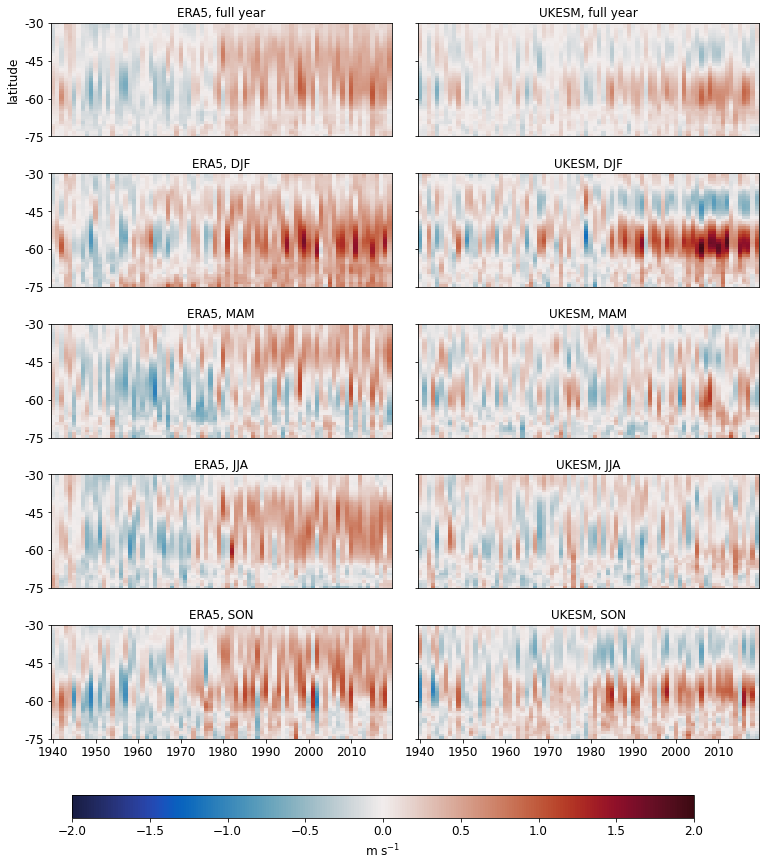

In [72]:
tt = True # for testing layout calculate only one hovmoller
tvmin = -2; tvmax = 2
tcm = cm.balance

fact = 0.9
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()
 
i = 0
w =xr.plot.pcolormesh(ylist_ERA_FY_trend, ax = axs[0+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_ERA_DJF_trend, ax = axs[2+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_ERA_MAM_trend, ax = axs[4+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_ERA_JJA_trend, ax = axs[6+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_ERA_SON_trend, ax = axs[8+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

i = 1
w =xr.plot.pcolormesh(ylist_UKESM_FY_trend, ax = axs[0+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_UKESM_DJF_trend, ax = axs[2+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_UKESM_MAM_trend, ax = axs[4+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_UKESM_JJA_trend, ax = axs[6+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
w =xr.plot.pcolormesh(ylist_UKESM_SON_trend, ax = axs[8+i], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)


for i in range(1,10):
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
for i in range(0,8):
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    
axs[0].set_ylabel('')
# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
axs[0].set_yticks(np.arange(-75,-15,15))
axs[0].set_yticklabels(np.arange(-75,-15,15))
axs[0].set_ylabel('latitude')    
    
for i in range(0,10):
    axs[i].set_ylim([-75,-30])
    
fs = 12

axs[0].set_title('ERA5, full year', fontsize = fs)
axs[2].set_title('ERA5, DJF', fontsize = fs)
axs[4].set_title('ERA5, MAM', fontsize = fs)
axs[6].set_title('ERA5, JJA', fontsize = fs)
axs[8].set_title('ERA5, SON', fontsize = fs)

ind = 1
axs[0+ind].set_title('UKESM, full year', fontsize = fs)
axs[2+ind].set_title('UKESM, DJF', fontsize = fs)
axs[4+ind].set_title('UKESM, MAM', fontsize = fs)
axs[6+ind].set_title('UKESM, JJA', fontsize = fs)
axs[8+ind].set_title('UKESM, SON', fontsize = fs)

for i in range(1,10):
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
axs[0].set_yticks(np.arange(-75,-15,15))
axs[0].set_yticklabels(np.arange(-75,-15,15))
axs[0].set_ylabel('latitude')    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')

axs[0].set_xlabel('')

plt.tight_layout()
plt.show()
#fig.savefig('./figs/Fig-hovmoller-diffraw.jpg')

## spatial MK

docs here: 
https://pypi.org/project/pymannkendall/

In [116]:

import pymannkendall as mk
# trend, h, p, z, Tau, s, var_s, slope, intercept \
#         = mk.original_test(test2)

## extraction code for Mann-Kendall

In [120]:
horse = False
if horse:
    
    UKESM_DJF = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'DJF')).\
    groupby('time_counter.year').mean().values
    UKESM_MAM = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'MAM')).\
    groupby('time_counter.year').mean().values
    UKESM_JJA = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'JJA')).\
    groupby('time_counter.year').mean().values
    UKESM_SON = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'SON')).\
    groupby('time_counter.year').mean().values
    UKESM_FY = ylist_UKESM.wspd10m.isel(lat=slice(0,60)).\
    groupby('time_counter.year').mean().values
    np.shape(UKESM_FY)

    ERA_DJF = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'DJF')).\
    groupby('time_counter.year').mean().values
    ERA_MAM = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'MAM')).\
    groupby('time_counter.year').mean().values
    ERA_JJA = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'JJA')).\
    groupby('time_counter.year').mean().values
    ERA_SON = ylist_ERA.wspd10m.isel(lat=slice(0,60)).sel(time_counter=(ylist_ERA['time_counter.season'] == 'SON')).\
    groupby('time_counter.year').mean().values
    ERA_FY = ylist_ERA.wspd10m.isel(lat=slice(0,60)).\
    groupby('time_counter.year').mean().values
    np.shape(ERA_FY)
    
    w = time.time()

    tdats = [UKESM_FY, UKESM_DJF, UKESM_MAM,UKESM_JJA, UKESM_SON]

    mk_slope = np.zeros([5,60,360])
    mk_p = np.zeros([5,60,360])

    for sc in range(0,5):
        testdat = tdats[sc]
        print(sc)
        for i in range(0,60):
            print(i)
            for j in range(0,360):
                tda = testdat[:,i,j]
                trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(tda)
                mk_slope[sc,i,j] = slope
                mk_p[sc,i,j] = p

    savenam = '/gpfs/data/greenocean/software/products/windsFromComponents/MannKendall/UKESM_1A_MK-1940-2020.nc'
    data_vars = {'mk_slope':(['season', 'lat', 'lon'], mk_slope,
    {'long_name':'MK, 1940-2020'}),
                 'mk_p':(['season', 'lat', 'lon'], mk_p,
    {'long_name':'MK, 1940-2020'}),
    }

    lats = ylist_UKESM.lat.isel(lat = slice(0,60)).values
    lons = ylist_UKESM.lon.values
    seasons = ['FY','DJF','MAM','JJA','SON']
    # define coordinates
    coords = {'season': (['season'], seasons),
            'lat': (['lat'], lats),
    'lon': (['lon'], lons),
             }
    # define global attributes
    attrs = {'made in':'windAnalyis/wspdComponents/FigMAP-HOV.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)

    w2 = time.time()
    print(w2-w)


    w = time.time()

    tdats = [ERA_FY, ERA_DJF, ERA_MAM,ERA_JJA, ERA_SON]

    mk_slope = np.zeros([5,60,360])
    mk_p = np.zeros([5,60,360])

    for sc in range(0,5):
        testdat = tdats[sc]
        print(sc)
        for i in range(0,60):
            print(i)
            for j in range(0,360):
                tda = testdat[:,i,j]
                trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(tda)
                mk_slope[sc,i,j] = slope
                mk_p[sc,i,j] = p

    savenam = '/gpfs/data/greenocean/software/products/windsFromComponents/MannKendall/ERA_MK-1940-2020.nc'
    data_vars = {'mk_slope':(['season', 'lat', 'lon'], mk_slope,
    {'long_name':'MK, 1940-2020'}),
                 'mk_p':(['season', 'lat', 'lon'], mk_p,
    {'long_name':'MK, 1940-2020'}),
    }

    lats = ylist_ERA.lat.isel(lat = slice(0,60)).values
    lons = ylist_ERA.lon.values
    seasons = ['FY','DJF','MAM','JJA','SON']
    # define coordinates
    coords = {'season': (['season'], seasons),
            'lat': (['lat'], lats),
    'lon': (['lon'], lons),
             }
    # define global attributes
    attrs = {'made in':'windAnalyis/wspdComponents/FigMAP-HOV.ipynb',
    'desc': ''
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)

    w2 = time.time()
    print(w2-w)


In [122]:
MK_UKESM = xr.open_dataset('/gpfs/data/greenocean/software/products/windsFromComponents/MannKendall/UKESM_1A_MK-1940-2020.nc')
MK_ERA = xr.open_dataset('/gpfs/data/greenocean/software/products/windsFromComponents/MannKendall/ERA_MK-1940-2020.nc')


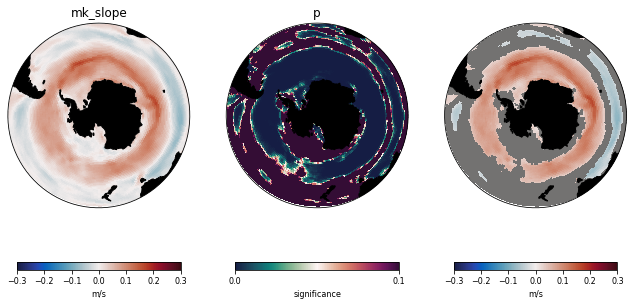

In [126]:
mk_slope = MK_UKESM.mk_slope[0,:,:]
mk_p = MK_UKESM.mk_p[0,:,:]
mk_slop_sig2 =np.copy(mk_slope)
mk_slop_sig2[mk_p>0.05] = 1 ##will be coloured grey when insignificant
mk_slop_sig2[mk_p<=0.05] = np.nan ## will be


fact = 0.25
fig = plt.figure(figsize=[60*fact, 66*fact])

tmi = -0.3; tma = 0.3
ax1 = fig.add_subplot(1, 4, 1, projection=ccrs.Orthographic(0, -90))
bc = plot_southern(fig, ax1, lons, lats[0:60], mk_slope*10, tmi, tma, np.arange(tmi,tma+0.05,0.1), fs = 12, 
              tit = 'mk_slope', cbarlab = 'm/s', tcmap = cm.balance, lm = True, cbr = True)

tmi = 0; tma = 0.1
ax1 = fig.add_subplot(1, 4, 2, projection=ccrs.Orthographic(0, -90))
bc = plot_southern(fig, ax1, lons, lats[0:60], mk_p, tmi, tma, np.arange(tmi,tma+0.05,0.1), fs = 12, 
              tit = 'p', cbarlab = 'significance', tcmap = cm.curl, lm = True, cbr = True)

tmi = -0.3; tma = 0.3
ax1 = fig.add_subplot(1, 4, 3, projection=ccrs.Orthographic(0, -90))
bc = plot_southern(fig, ax1, lons, lats[0:60], mk_slope*10, tmi, tma, np.arange(tmi,tma+0.05,0.1), fs = 12, 
              tit = 'mk_slope', cbarlab = 'm/s', tcmap = cm.balance, lm = True, cbr = True)
tmi = -0.3; tma = 20
bc = plot_southern(fig, ax1, lons, lats[0:60], mk_slop_sig2*10, tmi, tma, np.arange(tmi,tma+0.05,0.1), fs = 12, 
             cbarlab = 'm/s', tcmap = cm.gray, lm = True, cbr = False)



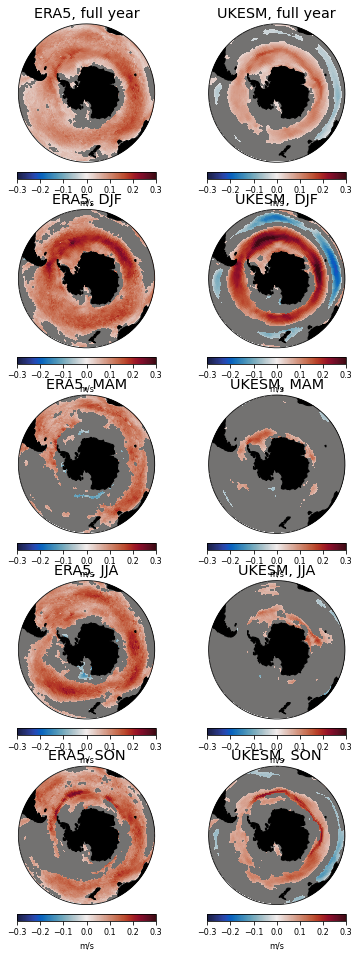

In [139]:
def plot_mk_with_sigmask(fig, ax1, mk_slope, mk_p, tmi = -0.3, tma = 0.3):
    tmi = tmi; tma = tma
    mk_slop_sig2 =np.copy(mk_slope)
    mk_slop_sig2[mk_p>0.05] = 1 ##will be coloured grey when insignificant
    mk_slop_sig2[mk_p<=0.05] = np.nan ## will be transparent, and original trend value will shine through
    bc = plot_southern(fig, ax1, lons, lats[0:60], mk_slope*10, tmi, tma, np.arange(tmi,tma+0.05,0.1), fs = 12, 
                  tit = 'mk_slope', cbarlab = 'm/s', tcmap = cm.balance, lm = True, cbr = True)
    tmi = -0.3; tma = 20
    bc = plot_southern(fig, ax1, lons, lats[0:60], mk_slop_sig2*10, tmi, tma, np.arange(tmi,tma+0.05,0.1), fs = 12, 
                 cbarlab = 'm/s', tcmap = cm.gray, lm = True, cbr = False)
    
fact = 0.25
fig = plt.figure(figsize=[25*fact, 66*fact])
tmi = -0.3; tma = 0.3

ind = 0; seas = 'full year'
ax1 = fig.add_subplot(5, 2, 1, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_ERA.mk_slope[0,:,:], MK_ERA.mk_p[0,:,:], tmi, tma)
ax1.set_title(f'ERA5, {seas}')
ax1 = fig.add_subplot(5, 2, 2, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_UKESM.mk_slope[0,:,:], MK_UKESM.mk_p[0,:,:], tmi, tma)
ax1.set_title(f'UKESM, {seas}')
ind = 1; seas = 'DJF'
ax1 = fig.add_subplot(5, 2, 1+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_ERA.mk_slope[ind,:,:], MK_ERA.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'ERA5, {seas}')
ax1 = fig.add_subplot(5, 2, 2+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_UKESM.mk_slope[ind,:,:], MK_UKESM.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'UKESM, {seas}')
ind = 2; seas = 'MAM'
ax1 = fig.add_subplot(5, 2, 1+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_ERA.mk_slope[ind,:,:], MK_ERA.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'ERA5, {seas}')
ax1 = fig.add_subplot(5, 2, 2+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_UKESM.mk_slope[ind,:,:], MK_UKESM.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'UKESM, {seas}')
ind = 3; seas = 'JJA'
ax1 = fig.add_subplot(5, 2, 1+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_ERA.mk_slope[ind,:,:], MK_ERA.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'ERA5, {seas}')
ax1 = fig.add_subplot(5, 2, 2+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_UKESM.mk_slope[ind,:,:], MK_UKESM.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'UKESM, {seas}')
ind = 4; seas = 'SON'
ax1 = fig.add_subplot(5, 2, 1+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_ERA.mk_slope[ind,:,:], MK_ERA.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'ERA5, {seas}')
ax1 = fig.add_subplot(5, 2, 2+2*ind, projection=ccrs.Orthographic(0, -90))
plot_mk_with_sigmask(fig, ax1, MK_UKESM.mk_slope[ind,:,:], MK_UKESM.mk_p[ind,:,:], tmi, tma)
ax1.set_title(f'UKESM, {seas}')

plt.tight_layout()